## Burger's equation: Two-step Method

In [34]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [35]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import * 
from models import *
from data_loader_Burgers2 import * 

import matplotlib.tri as tri
import matplotlib.pyplot as plt

from jax.config import config; 
config.update("jax_enable_x64", True)

In [36]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [37]:
# 2-step dictionary
keys = ['optim_sgm_u','optim_nugget_u','rkhs_u','optim_sgm_P','optim_nugget_P','nugget_P', 'rkhs_P_train', 'rkhs_P_train', 'f_pred_test']
two_step_dict = dict.fromkeys(keys)

### Solution: Two-Step Method

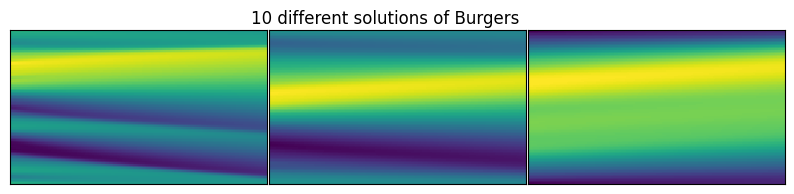

In [38]:
# u values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('10 different solutions of Burgers')
axs = axs.ravel()
for i in range(m): 
    axs[i].pcolormesh(t, x, U[i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

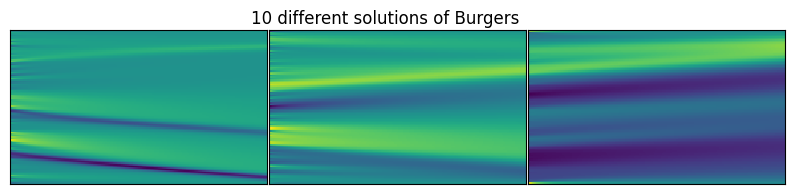

In [39]:
# u_t values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('10 different solutions of Burgers')
axs = axs.ravel()
for i in range(m): 
    axs[i].pcolormesh(t, x, U_t[i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

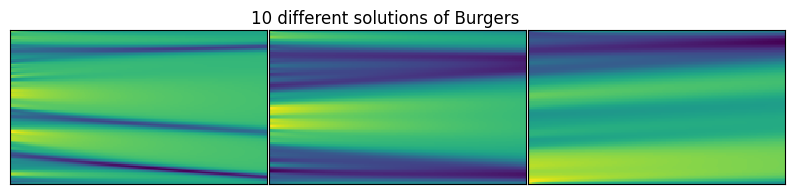

In [40]:
# u_x values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('10 different solutions of Burgers')
axs = axs.ravel()
for i in range(m): 
    axs[i].pcolormesh(t, x, U_x[i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

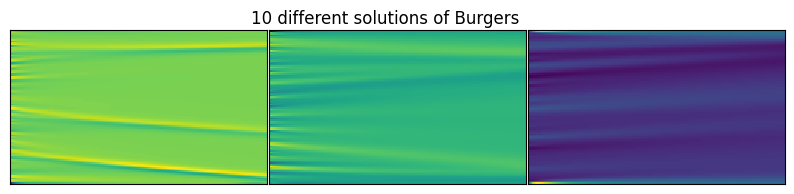

In [41]:
# u_xx values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('10 different solutions of Burgers')
axs = axs.ravel()
for i in range(m): 
    axs[i].pcolormesh(t, x, U_xx[i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

### > Step 1: Learning $u's$

In [42]:
print(U_train.shape)

(20, 3)


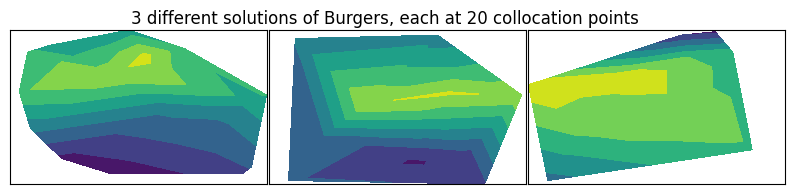

In [43]:
# u values at collocation points of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('{} different solutions of Burgers, each at {} collocation points'.format(m, N_train))
axs = axs.ravel()
for i in range(m):
    axs[i].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], U_train[:,i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

In [44]:
# Learn alphas and lenght scale
optim_sgm_u, alphas, optim_nugget_u = kernel_parameters_Gaussian_2D(X_train, U_train, N_train)

In [45]:
# Save true values to be used in one-step
two_step_dict['optim_sgm_u'] = optim_sgm_u 
two_step_dict['optim_nugget_u'] = optim_nugget_u 
optim_sgm_u, optim_nugget_u

(array([3.02114284, 4.24311643, 6.50030938]), array([1.e-14, 1.e-08, 1.e-08]))

In [46]:
# Predict using interpolant and get its gradients
u_pred_train, u_t_pred_train, u_x_pred_train, u_xx_pred_train = predictions_Burgers(X_train, X_train, Gaussian2D, optim_sgm_u, alphas, N_train, N_test)
u_pred_test, u_t_pred_test, u_x_pred_test, u_xx_pred_test = predictions_Burgers(X_test, X_train, Gaussian2D, optim_sgm_u, alphas, N_train, N_test)

In [47]:
# Save true values to warm up the onepfive method
np.save('data/u_pred_train.npy', u_pred_train)
np.save('data/u_pred_test.npy', u_pred_test)
# Save true gradients for comparing later  
np.save('data/u_t_train.npy',u_t_train) 
np.save('data/u_x_train.npy',u_x_train) 
np.save('data/u_xx_train.npy',u_xx_train) 
# Save gradients for one step method
np.save('data/u_x_pred_train.npy',u_x_pred_train)
np.save('data/u_xx_pred_train.npy',u_xx_pred_train)
np.save('data/u_x_pred_test.npy',u_x_pred_test)
np.save('data/u_xx_pred_test.npy',u_xx_pred_test)

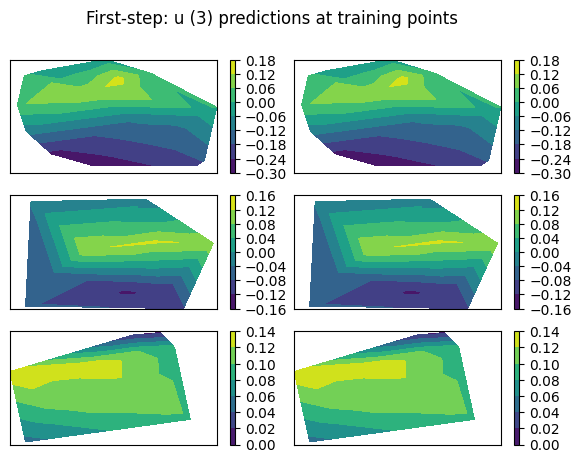

In [48]:
# Plot: u at training points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], U_train[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], u_pred_train[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

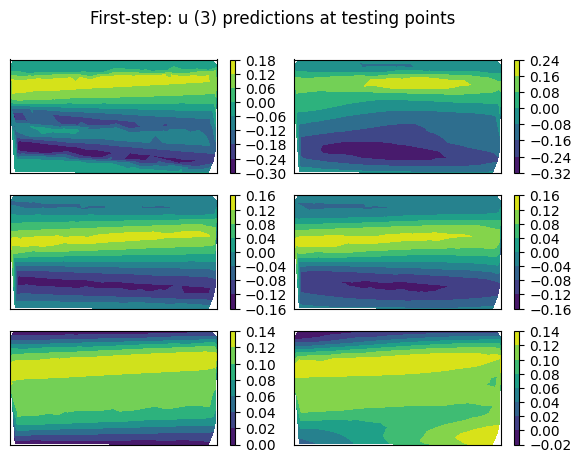

In [49]:
# Plot: u at testing points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_test[i*N_test:(i+1)*N_test,0], X_test[i*N_test:(i+1)*N_test,1], U_test[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_test[i*N_test:(i+1)*N_test,0], X_test[i*N_test:(i+1)*N_test,1], u_pred_test[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [50]:
# NMSEs: u at training points and testing points
print('Normalized MSEs between u and u_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(u_pred_train[:,i], U_train[:,i])/mean_squared_error(u_pred_train[:,i]*0, U_train[:,i])
    n_mse_test = mean_squared_error(u_pred_test[:,i], U_test[:,i])/mean_squared_error(u_pred_test[:,i]*0, U_test[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u and u_pred for 3 functions
m = 0 nmse_train = 4.319689378181703e-27
m = 0 nmse_test = 0.1876380723822643
m = 1 nmse_train = 5.130129875358635e-13
m = 1 nmse_test = 0.01782009953469715
m = 2 nmse_train = 1.1169949331132723e-11
m = 2 nmse_test = 0.0668893977725906


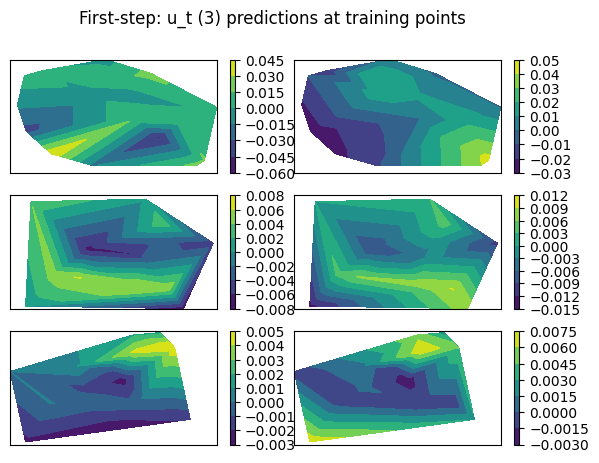

In [51]:
# Plot: u_t at training points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_t ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], U_t_train[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], u_t_pred_train[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

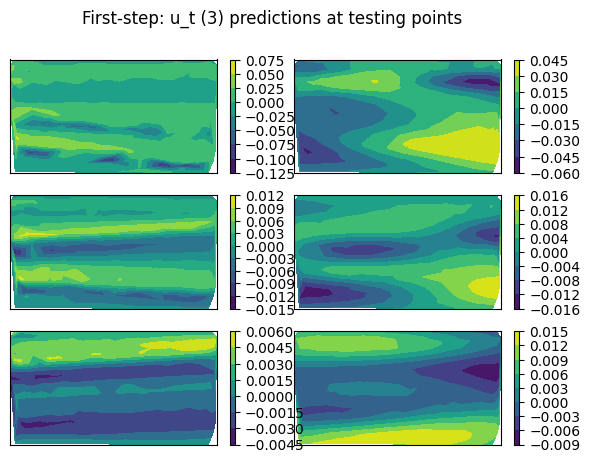

In [52]:
# Plot: u_t at testing points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_t ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_test[i*N_test:(i+1)*N_test,0], X_test[i*N_test:(i+1)*N_test,1], U_t_test[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_test[i*N_test:(i+1)*N_test,0], X_test[i*N_test:(i+1)*N_test,1], u_t_pred_test[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [53]:
# NMSEs: u_t at training points and testing points
print('Normalized MSEs between u_t and u_t_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(u_t_pred_train[:,i], U_t_train[:,i])/mean_squared_error(u_t_pred_train[:,i]*0, U_t_train[:,i])
    n_mse_test = mean_squared_error(u_t_pred_test[:,i], U_t_test[:,i])/mean_squared_error(u_t_pred_test[:,i]*0, U_t_test[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u_t and u_t_pred for 3 functions
m = 0 nmse_train = 1.717389893131262
m = 0 nmse_test = 1.6288823457466852
m = 1 nmse_train = 1.3067181834309096
m = 1 nmse_test = 1.6576195625363006
m = 2 nmse_train = 1.8733564088432169
m = 2 nmse_test = 5.89411795544687


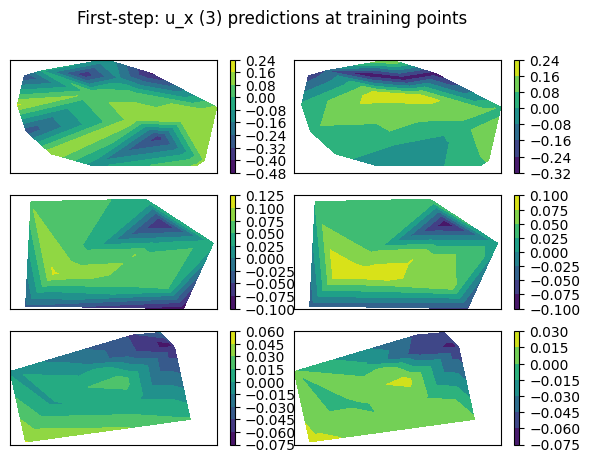

In [54]:
# Plot: u_x at training points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_x ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], U_x_train[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], u_x_pred_train[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

plt.show()

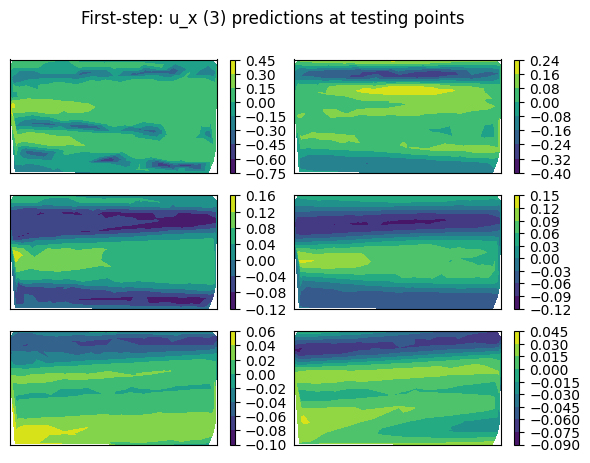

In [55]:
# Plot: u_x at testing points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_x ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_test[i*N_test:(i+1)*N_test,0], X_test[i*N_test:(i+1)*N_test,1], U_x_test[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_test[i*N_test:(i+1)*N_test,0], X_test[i*N_test:(i+1)*N_test,1], u_x_pred_test[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [56]:
# NMSEs: u_x at training points and testing points
print('Normalized MSEs between u_x and u_x_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(u_x_pred_train[:,i], U_x_train[:,i])/mean_squared_error(u_x_pred_train[:,i]*0, U_x_train[:,i])
    n_mse_test = mean_squared_error(u_x_pred_test[:,i], U_x_test[:,i])/mean_squared_error(u_x_pred_test[:,i]*0, U_x_test[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u_x and u_x_pred for 3 functions
m = 0 nmse_train = 0.5713731602607021
m = 0 nmse_test = 0.7194182467455754
m = 1 nmse_train = 0.05617976679839173
m = 1 nmse_test = 0.09472370844225397
m = 2 nmse_train = 0.12546743218072764
m = 2 nmse_test = 0.3750540581254201


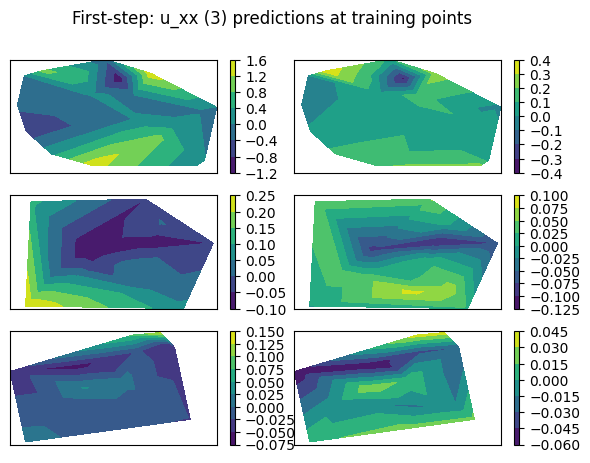

In [57]:
# Plot: u_xx at training points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_xx ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], U_xx_train[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], u_xx_pred_train[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

plt.show()

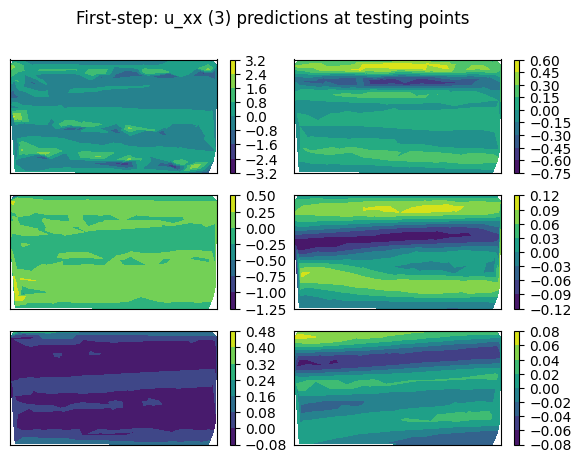

In [58]:
# Plot: u_xx at testing points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_xx ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_test[i*N_test:(i+1)*N_test,0], X_test[i*N_test:(i+1)*N_test,1], U_xx_test[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_test[i*N_test:(i+1)*N_test,0], X_test[i*N_test:(i+1)*N_test,1], u_xx_pred_test[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [59]:
# NMSEs: u_xx at training points and testing points
print('Normalized MSEs between u_xx and u_xx_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(u_xx_pred_train[:,i], U_xx_train[:,i])/mean_squared_error(u_xx_pred_train[:,i]*0, U_xx_train[:,i])
    n_mse_test = mean_squared_error(u_xx_pred_test[:,i], U_xx_test[:,i])/mean_squared_error(u_xx_pred_test[:,i]*0, U_xx_test[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u_xx and u_xx_pred for 3 functions
m = 0 nmse_train = 0.7019081237003386
m = 0 nmse_test = 0.9522119236439525
m = 1 nmse_train = 0.7052220252687382
m = 1 nmse_test = 0.8017610646363292
m = 2 nmse_train = 0.39074009820911515
m = 2 nmse_test = 0.7456100322785641


RKHSs norms squared $u^*$

In [60]:
rkhs_u = []
G = K_2D(Gaussian2D, X_train, X_train, optim_sgm_u)
G = G[:,:,0] + 1e-7*jnp.diag(jnp.diag(G[:,:,0])) # I had to regularize here (?)
alphas = np.linalg.solve(G, u_pred_train.flatten())
rkhs_u.append(np.dot(u_pred_train.flatten(),alphas))
# Print the norm
print('RKHS^2 norm of u^*: {}'.format(round(rkhs_u[0],2)))
# Save true values to be used in 1-step
two_step_dict['rkhs_u'] = rkhs_u

RKHS^2 norm of u^*: 895161.57


We compute the norm of $u_*$ since it is more regular than $u$.

> Step 2: Learning $P$

In [61]:
s_train = np.hstack((X_train,U_train.T.reshape(-1,1),u_x_pred_train.T.reshape(-1,1),u_xx_pred_train.T.reshape(-1,1))) # (m*N_train, 5)
s_test = np.hstack((X_test,U_test.T.reshape(-1,1),u_x_pred_test.T.reshape(-1,1),u_xx_pred_test.T.reshape(-1,1))) # (m*N_test, 5)

f_train = U_t_train.T.reshape(-1,1)
f_test = U_t_test.T.reshape(-1,1)

scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(s_train)
s_test_s = scaler_s_train.transform(s_test)

f_train2 = -s_train[:,2]*s_train[:,3] + 0.01*s_train[:,4]
f_test2 = -s_test[:,2]*s_test[:,3] + 0.01*s_test[:,4]

In [62]:
#optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s,f_train)
optim_d_P, optim_nugget_P = 2, 1e-16
# Save true values to be used in one-step
two_step_dict['optim_sgm_P'] = optim_sgm_P
two_step_dict['optim_nugget_P'] = optim_nugget_P

#krr_optimal_P = KernelRidge(kernel='rbf', alpha = optim_nugget_P, gamma=1/(2*(optim_sgm_P**2))) 
krr_optimal_P = KernelRidge(kernel='poly', alpha = optim_nugget_P, degree = optim_d_P) 

krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_train = f_pred_train.flatten() 
f_pred_test = krr_optimal_P.predict(s_test_s)
f_pred_test = f_pred_test.flatten() 

In [63]:
print('Optimal sigma of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_sgm_P,optim_nugget_P))
#print('Degree for kernel of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_d_P,optim_nugget_P))

Optimal sigma of P^*:0.0006795808434656559  Nugget of P^*: 1.00e-16


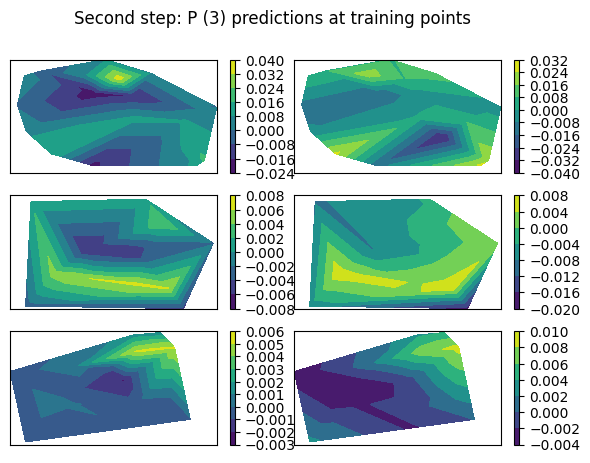

In [64]:
# Plot: P at training points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], f_train2[i*N_train:(i+1)*N_train])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], f_pred_train[i*N_train:(i+1)*N_train])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

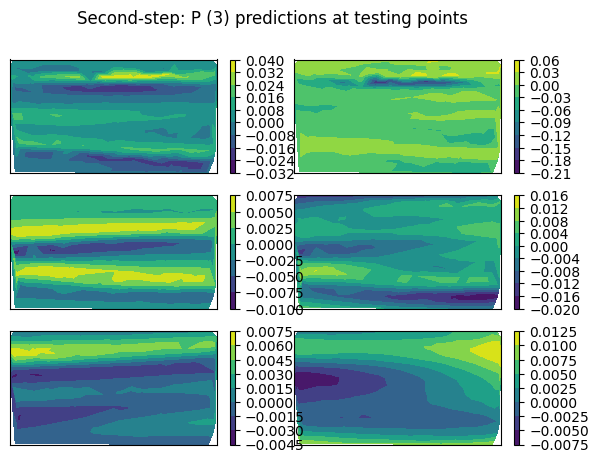

In [65]:
# Plot: P at testing points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second-step: P ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_test[i*N_test:(i+1)*N_test,0], X_test[i*N_test:(i+1)*N_test,1], f_test2[i*N_test:(i+1)*N_test])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_test[i*N_test:(i+1)*N_test,0], X_test[i*N_test:(i+1)*N_test,1], f_pred_test[i*N_test:(i+1)*N_test])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [66]:
# NMSEs: u_xx at training points and testing points
print('Normalized MSEs between P and P^ for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(f_pred_train[i*N_train:(i+1)*N_train], f_train2[i*N_train:(i+1)*N_train])/mean_squared_error(f_pred_train[i*N_train:(i+1)*N_train]*0, f_train2[i*N_train:(i+1)*N_train])
    n_mse_test = mean_squared_error(f_pred_test[i*N_test:(i+1)*N_test], f_test2[i*N_test:(i+1)*N_test])/mean_squared_error(f_pred_test[i*N_test:(i+1)*N_test]*0, f_test2[i*N_test:(i+1)*N_test])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between P and P^ for 3 functions
m = 0 nmse_train = 0.9600991215083486
m = 0 nmse_test = 8.69213863980478
m = 1 nmse_train = 1.1547682324023578
m = 1 nmse_test = 1.9433029609319703
m = 2 nmse_train = 1.1512673402968256
m = 2 nmse_test = 2.3091202831780038


In [34]:
# 1. Polynomial for learning P. 
# 2. 1*RBF(lambda=1) + 1*Polynomial for learning P. Suggested by H.
# 3. Supergrid (32000) < 256(2**d) GHOST in a UNIFORM GRID (same per fun) < 20 COLLOCATION(different per fun)
# 4. Supergrid (32000) < 500 TEST (same per fun)

RKHS norm squared of $P^*$

In [21]:
# rkhs_P
nugget_P = 1e-7
G = K(Gaussian,s_train_s,s_train_s, optim_sgm_P) + nugget_P*np.eye(X_train.shape[0]) # added nugget here !
alphas_P = np.linalg.solve(G, f_pred_train)
rkhs_P_train = np.dot(f_pred_train, alphas_P)
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_train,2)))
# Save true values to be used in one-step
two_step_dict['rkhs_P_train'] = rkhs_P_train
two_step_dict['nugget_P'] = nugget_P

RKHS^s norm of P^*: 591.24


In [22]:
# rkhs_P
nugget_P = 1e-7
G_test = K(Gaussian,s_test_s,s_test_s, optim_sgm_P) + nugget_P*np.eye(X_test.shape[0]) # added nugget here !
alphas_P_test = np.linalg.solve(G_test, f_pred_test)
rkhs_P_test = np.dot(f_pred_test,alphas_P_test)
two_step_dict['rkhs_P_test'] = rkhs_P_test
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_test,2)))

RKHS^s norm of P^*: 995.04


In [23]:
two_step_dict['f_pred_test'] = f_pred_test

Test

> Compute std of feature 1 $\sigma_{\text{s[:,1]}}$ of `s_train` and perturb feature 1 of `s_train` using $m \sigma_{\text{s[:,1]}}$ each element. $m \in (0.01,0.25)$.

100%|██████████| 5/5 [26:50<00:00, 322.10s/it]


[[0.00307987 0.13285362 0.30589581 0.47842248 0.37091069]
 [0.00307987 0.2615827  0.53098458 0.22173562 0.31531827]
 [0.00307987 0.18088923 0.21308083 0.3051382  0.32314866]
 [0.00307987 0.11354046 0.21460885 0.27097627 0.43450826]
 [0.00307987 0.15066337 0.15752977 0.29815324 0.37374778]]


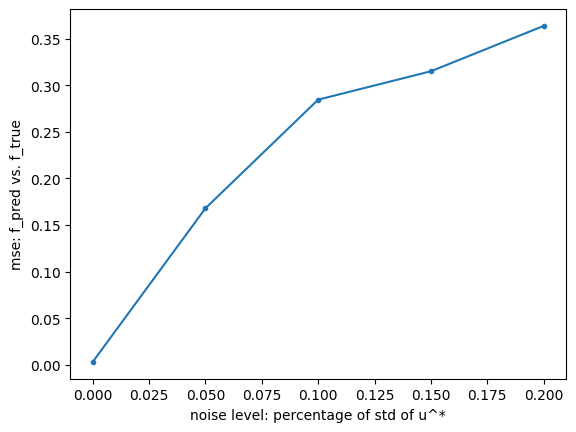

In [66]:
mses_P_all = []
for j in tqdm(range(5)):
    # Compute std per feature of s_train_s
    stds = np.std(s_train, axis = 0)
    beta = np.arange(0.0,0.25,0.05)
    scales = np.outer(beta, stds) 
    mses_P = []
    for i in tqdm(range(len(scales))):
        # Scales for current iteration
        scale = scales[i,:]
        # Copy s_train
        s_test = np.copy(s_train)
        # Perturb feature that contains u^* - Do this 10 times and average !!!
        s_test[:,2] = np.random.normal(s_train[:,2] , scale = scale[2])
        # Apply step one to perturbed u's 
        optim_sgm, alphas, optim_lmbd = kernel_parameters_Gaussian_2D(X_train, s_test[:,2].reshape(-1,1), e)
        _, _, u_x_pred, u_xx_pred = predictions_Burgers(X_train, X_train, Gaussian2D, optim_sgm, alphas, e , e)
        s_test[:,3] = u_x_pred.T.reshape(-1,1).flatten()
        s_test[:,4] = u_xx_pred.T.reshape(-1,1).flatten()
        # Scale the new s_test
        s_test_s = scaler_s_train.transform(s_test)
        # Compute predictions on test
        f_pred_test = krr_optimal_P.predict(s_test_s)
        # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
        f_true_test = -s_test[:,2]*s_test[:,3] + 0.1*s_test[:,4]
        # Compute mse per scale 
        mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
    mses_P_all.append(mses_P)
mses_P_all = np.array(mses_P_all)
print(mses_P_all)
mean_mses_P_all = np.mean(mses_P_all, axis = 0)
plt.plot(beta,mean_mses_P_all,'.-')
plt.xlabel('noise level: percentage of std of u^*')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

In [24]:
np.save('data/two_step_dict.npy',two_step_dict)